In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
import dame_flame

dtype_map = {
    'NCESDistrictID': 'string',
    'NCESSchoolID': 'string',
    'StateAssignedDistID': 'string',
    'Flag_AssmtNameChange': 'string',
    'Flag_CutScoreChange_ELA': 'string',
    'Flag_CutScoreChange_math': 'string',
    'Flag_CutScoreChange_sci': 'string',
    'Flag_CutScoreChange_soc': 'string',
    'DistType': 'string',
    'DistCharter': 'string',
    'DistLocale': 'string',
    'SchType': 'string',
    'SchLevel': 'string',
    'SchVirtual': 'string',
}

df = pd.read_csv("data/merged_df_clean.csv", dtype=dtype_map, low_memory=False)


# Step 2: Ensure numeric columns are properly parsed
numeric_cols = [
    'Per Pupil Expenditure', 'AvgScaleScore', 'Year_final',
    'StudentGroup_TotalTested', 'StudentSubGroup_TotalTested',
    'Lev1_percent', 'Lev2_percent', 'Lev3_percent', 'Lev4_percent', 'Lev5_percent',
    'Lev1_count', 'Lev2_count', 'Lev3_count', 'Lev4_count', 'Lev5_count',
    'ProficientOrAbove_percent', 'ProficientOrAbove_count', 'ParticipationRate',
    'Grade_numeric',"Total Revenue (TOTALREV) per Pupil (V33)",
    "American Indian/Alaska Native - female", "American Indian/Alaska Native - male",
    "Asian or Asian/Pacific Islander - female", "Asian or Asian/Pacific Islander - male",
    "Black or African American - female", "Black or African American - male",
    "Hispanic - female", "Hispanic - male",
    "Nat. Hawaiian or Other Pacific Isl. - female", "Nat. Hawaiian or Other Pacific Isl. - male",
    "Two or More Races - female", "Two or More Races - male",
    "White - female", "White - male"
]

for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Step 3: Clean and standardize string/categorical columns
str_cols = ['State', 'Subject', 'GradeLevel',
            'StudentGroup', 'DistName', 'SchName']
for col in str_cols:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip()

df['Year_clean'] = df['SchYear_clean']

df["Year_clean"] = pd.to_numeric(df["Year_clean"], errors="coerce")
cpi_index = { # data pulled from https://www.bls.gov/cpi/tables/supplemental-files/historical-cpi-u-202402.pdf
    2010: 218.056,
    2011: 224.939,
    2012: 229.594,
    2013: 232.957,
    2014: 236.736,
    2015: 237.017,
    2016: 240.007,
    2017: 245.120,
    2018: 251.107,
    2019: 255.657,
    2020: 258.811,
    2021: 270.970,
    2022: 292.655,
    2023: 304.702
}

# Map CPI factor for each row
df["cpi_factor"] = df["Year_clean"].map(lambda y: cpi_index.get(y, np.nan))

# Convert to 2020 dollars
df["Per Pupil Expenditure (adj)"] = (
    df["Per Pupil Expenditure"] / df["cpi_factor"] * cpi_index[2020]
)
df["Per Pupil Revenue (adj)"] = (
    df["Total Revenue (TOTALREV) per Pupil (V33)"] / df["cpi_factor"] * cpi_index[2020]
    )

In [2]:
# turn counts to percent. Only group by race as we do not care about gender.
df["Total_Students"] = df[[
    "American Indian/Alaska Native - female", "American Indian/Alaska Native - male",
    "Asian or Asian/Pacific Islander - female", "Asian or Asian/Pacific Islander - male",
    "Black or African American - female", "Black or African American - male",
    "Hispanic - female", "Hispanic - male",
    "Nat. Hawaiian or Other Pacific Isl. - female", "Nat. Hawaiian or Other Pacific Isl. - male",
    "Two or More Races - female", "Two or More Races - male",
    "White - female", "White - male"
]].sum(axis=1)
df["pct_black"] = (df["Black or African American - female"] + df["Black or African American - male"]) / df["Total_Students"]
df["pct_white"] = (df["White - female"] + df["White - male"]) / df["Total_Students"]
df["pct_hispanic"] = (df["Hispanic - female"] + df["Hispanic - male"]) / df["Total_Students"]
df["pct_asian"] = (df["Asian or Asian/Pacific Islander - female"] + df["Asian or Asian/Pacific Islander - male"]) / df["Total_Students"]
df["pct_native"] = (df["American Indian/Alaska Native - female"] + df["American Indian/Alaska Native - male"]) / df["Total_Students"]
df["pct_multiracial"] = (df["Two or More Races - female"] + df["Two or More Races - male"]) / df["Total_Students"]
df["pct_pacific"] = (df["Nat. Hawaiian or Other Pacific Isl. - female"] + df["Nat. Hawaiian or Other Pacific Isl. - male"]) / df["Total_Students"]
df.replace([np.inf, -np.inf], np.nan, inplace=True)


In [3]:
# : bin into 4 quantiles (matching needs groups) Each race now has 4 quantiles
race_props = ['pct_black', 'pct_white', 'pct_hispanic', 'pct_asian', 'pct_native', 'pct_multiracial', 'pct_pacific']
for col in race_props:
    if df[col].notna().sum() > 0:
        df[f"{col}_bin"] = pd.qcut(df[col], q=4, duplicates="drop").astype(str)

In [4]:
# remove 0$ Revenue rows
df = df[
    (df["Per Pupil Revenue (adj)"] > 0)
] 
# Sort by district and year (not really needed but good anyway)
df1 = df.sort_values(["DistrictName_clean", "Year_clean"])

# Compute lagged revenue and lagged year
df1["Per Pupil Revenue (adj, lag1)"] = df1.groupby("DistrictName_clean")["Per Pupil Revenue (adj)"].shift(1)
df1["Year_lag1"] = df1.groupby("DistrictName_clean")["Year_clean"].shift(1)

# Keep only rows where the lag year is exactly one less
df_lagged = df1[df1["Year_clean"] - df1["Year_lag1"] == 1].copy()
# we will lose two years of data as we do not have the past Revenue for that year.

In [5]:
# test to see how many rows we will have for matching (not many)
# # Filter non-null rows
# filtered_df = df[["DistrictName_clean", "Grade_numeric", "Year_clean", 
#                   "Per Pupil Revenue (adj, lag1)", "Per Pupil Revenue (adj)"]].dropna()

# # Group and sort
# grouped = filtered_df.sort_values(["DistrictName_clean", "Grade_numeric", "Year_clean"])

# # Display or inspect
# print(grouped)
# print(grouped[["DistrictName_clean", "Grade_numeric", "Year_clean", "Per Pupil Revenue (adj, lag1)", "Per Pupil Revenue (adj)"]])

In [6]:
import numpy as np
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

def prepare_matching_data(
    df,
    outcome_col="ProficientOrAbove_percent",
    treatment_col="Per Pupil Revenue (adj)",
    threshold_quantile=0.5,
    match_vars=None
):
    if match_vars is None:
        match_vars = [
            'Grade_numeric', 'Year_clean', 'State', 'DistLocale',
            'DistCharter', 'DistType', 'Subject',
            'pct_black_bin', 'pct_white_bin', 'pct_hispanic_bin', 'pct_asian_bin',
            'pct_native_bin', 'pct_multiracial_bin', 'pct_pacific_bin'
        ]

    # Step 1: Filter rows with non-null treatment & outcome
    reg_df = df[
        df[outcome_col].notna() & df[treatment_col].notna()
    ].copy()

    # Step 2: Define treatment based on threshold
    threshold = reg_df[treatment_col].quantile(threshold_quantile)
    reg_df["treatment"] = (reg_df[treatment_col] >= threshold).astype(int)

    # Step 3: Subset relevant columns
    subset_cols = ["treatment", outcome_col] + match_vars
    subset_df = reg_df[subset_cols].dropna().copy()

    # Step 4: Rename outcome column
    subset_df = subset_df.rename(columns={outcome_col: "outcome"})

    # Step 5: Encode categorical variables
    category_encoders = {}
    for col in match_vars:
        cat_col = subset_df[col].astype("category")
        subset_df[col] = cat_col.cat.codes
        category_encoders[col] = cat_col.cat.categories

    subset_df = subset_df.reset_index(drop=True)

    return subset_df, category_encoders, threshold


In [7]:
import matplotlib.pyplot as plt
from dame_flame import matching

def run_dame_matching(matching_df, early_stop_iterations=float('inf'), verbose=3):
    model = matching.DAME(
        repeats=False,
        verbose=verbose,
        want_pe=True,
        early_stop_iterations=early_stop_iterations, 
        stop_unmatched_t=True,
        early_stop_un_c_frac=0.2,         # Stop when ≤80% of treated are matched
    )
    model.fit(
        matching_df,
        treatment_column_name="treatment",
        outcome_column_name="outcome"
    )
    results = model.predict(matching_df)

    # Plot PE over iterations
    pe_values = model.pe_each_iter
    plt.figure(figsize=(8, 5))
    plt.plot(range(len(pe_values)), pe_values, marker='o')
    plt.title("DAME Matching - Predictive Error by Iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Predictive Error")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return model, results



🔧 Running match: outcome=AvgScaleScore, treatment=Per Pupil Expenditure (adj)
Completed iteration 0 of matching
	Number of matched groups formed in total:  24
	Unmatched treated units:  1066 out of a total of  1090 treated units
	Unmatched control units:  1044 out of a total of  1068 control units
	Number of matches made this iteration:  48
	Number of matches made so far:  48
	Covariates dropped so far:  set()
	Predictive error of covariate set used to match:  52.08338935350736
Completed iteration 1 of matching
	Number of matched groups formed in total:  24
	Unmatched treated units:  1066 out of a total of  1090 treated units
	Unmatched control units:  1044 out of a total of  1068 control units
	Number of matches made this iteration:  0
	Number of matches made so far:  48
	Covariates dropped so far:  frozenset({'DistType'})
	Predictive error of covariate set used to match:  52.08338935350735
Completed iteration 2 of matching
	Number of matched groups formed in total:  24
	Unmatched tr

/tmp/ipykernel_32701/568242119.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


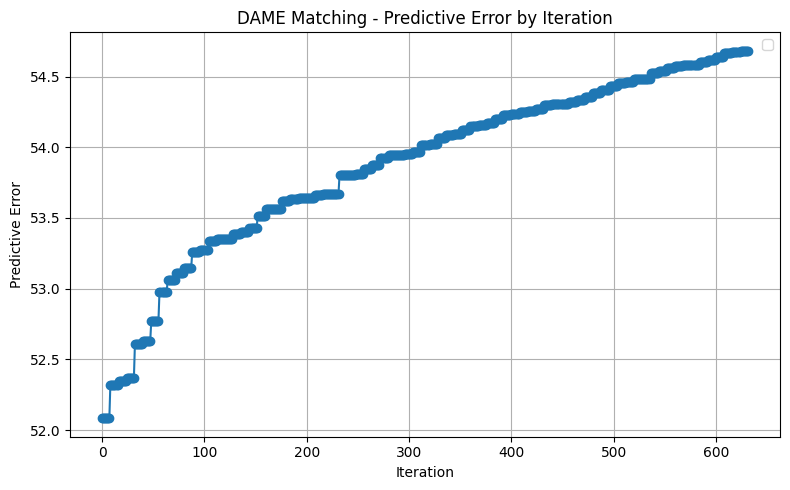


🔧 Running match: outcome=ProficientOrAbove_percent, treatment=Per Pupil Expenditure (adj)
Completed iteration 0 of matching
	Number of matched groups formed in total:  106
	Unmatched treated units:  5823 out of a total of  5945 treated units
	Unmatched control units:  5823 out of a total of  5941 control units
	Number of matches made this iteration:  240
	Number of matches made so far:  240
	Covariates dropped so far:  set()
	Predictive error of covariate set used to match:  0.038604930791541765
Completed iteration 1 of matching
	Number of matched groups formed in total:  106
	Unmatched treated units:  5823 out of a total of  5945 treated units
	Unmatched control units:  5823 out of a total of  5941 control units
	Number of matches made this iteration:  0
	Number of matches made so far:  240
	Covariates dropped so far:  frozenset({'pct_pacific_bin'})
	Predictive error of covariate set used to match:  0.03861396981571372
Completed iteration 2 of matching
	Number of matched groups forme

/tmp/ipykernel_32701/568242119.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


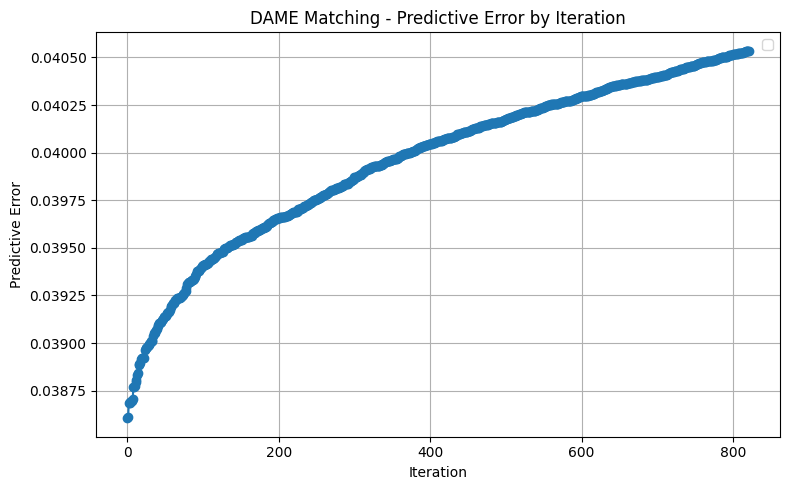


🔧 Running match: outcome=ProficientOrAbove_percent, treatment=Per Pupil Revenue (adj, lag1)
Completed iteration 0 of matching
	Number of matched groups formed in total:  5
	Unmatched treated units:  329 out of a total of  335 treated units
	Unmatched control units:  329 out of a total of  334 control units
	Number of matches made this iteration:  11
	Number of matches made so far:  11
	Covariates dropped so far:  set()
	Predictive error of covariate set used to match:  0.033879219250447665
Completed iteration 1 of matching
	Number of matched groups formed in total:  5
	Unmatched treated units:  329 out of a total of  335 treated units
	Unmatched control units:  329 out of a total of  334 control units
	Number of matches made this iteration:  0
	Number of matches made so far:  11
	Covariates dropped so far:  frozenset({'Subject'})
	Predictive error of covariate set used to match:  0.033879219250447665
Completed iteration 2 of matching
	Number of matched groups formed in total:  11
	Unm

/tmp/ipykernel_32701/568242119.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


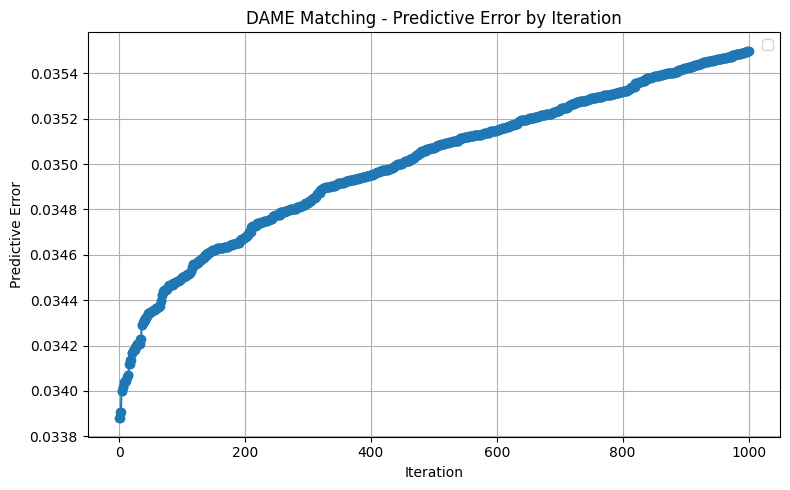


🔧 Running match: outcome=AvgScaleScore, treatment=Per Pupil Revenue (adj, lag1)
Completed iteration 0 of matching
	Number of matched groups formed in total:  2
	Unmatched treated units:  73 out of a total of  75 treated units
	Unmatched control units:  73 out of a total of  75 control units
	Number of matches made this iteration:  4
	Number of matches made so far:  4
	Covariates dropped so far:  set()
	Predictive error of covariate set used to match:  14.195438811727726
Completed iteration 1 of matching
	Number of matched groups formed in total:  2
	Unmatched treated units:  73 out of a total of  75 treated units
	Unmatched control units:  73 out of a total of  75 control units
	Number of matches made this iteration:  0
	Number of matches made so far:  4
	Covariates dropped so far:  frozenset({'DistCharter'})
	Predictive error of covariate set used to match:  14.195438811727733
Completed iteration 2 of matching
	Number of matched groups formed in total:  2
	Unmatched treated units:  7

/tmp/ipykernel_32701/568242119.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


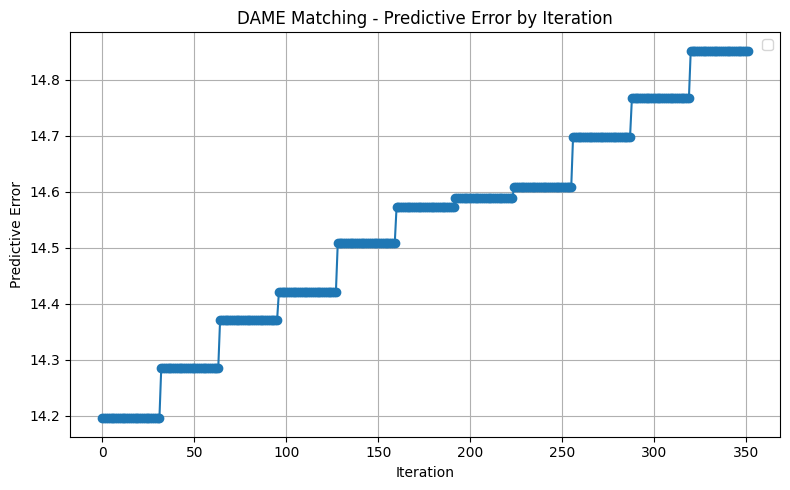

In [8]:
# Did this for the other matching can replace df with df_small do test with this
df_small = df[
    (df["Per Pupil Expenditure (adj)"] <= 12000)]
combinations = [
    ("AvgScaleScore", "Per Pupil Expenditure (adj)",df),
    ("ProficientOrAbove_percent", "Per Pupil Expenditure (adj)",df),
    ("ProficientOrAbove_percent", "Per Pupil Revenue (adj, lag1)",df_lagged),
    ("AvgScaleScore", "Per Pupil Revenue (adj, lag1)",df_lagged),
]

models = {}

for outcome_col, treatment_col,df1 in combinations:
    print(f"\n🔧 Running match: outcome={outcome_col}, treatment={treatment_col}")
    matching_df, encoders, threshold = prepare_matching_data(df1, outcome_col, treatment_col)
    model, results = run_dame_matching(matching_df, early_stop_iterations=1000) #we really need more data so matching is less strict.
    models[(outcome_col, treatment_col)] = (model, results)

In [22]:
# Nicks code fixed for small error
def get_dataframe(model, result_of_fit):
    # Get original data
    better = model.input_data.loc[result_of_fit.index]
    if not better.index.is_unique:
        raise ValueError("Need index values in input data to be unique")
    # Get match groups for clustering
    better["match_group"] = np.nan
    better["match_group_size"] = np.nan
    for idx, group in enumerate(model.units_per_group):
        better.loc[group, "match_group"] = idx
        better.loc[group, "match_group_size"] = len(group)
    # Get weights. I THINK this is right?! At least for with repeat=False?
    t = model.treatment_column_name
    better["t_in_group"] = better.groupby("match_group")[t].transform(np.sum)

    # Make weights
    better["weights"] = np.nan
    better.loc[better[t] == 1, "weights"] = 1  # treaments are 1

    # Controls start as proportional to num of treatments
    # each observation is matched to.
    better.loc[better[t] == 0, "weights"] = better["t_in_group"] / (
        better["match_group_size"] - better["t_in_group"]
    )

    # Then re-normalize for num unique control observations.
    control_weights = better[better[t] == 0]["weights"].sum()

    num_control_obs = len(better[better[t] == 0].index.drop_duplicates())
    renormalization = num_control_obs / control_weights
    better.loc[better[t] == 0, "weights"] = (
        better.loc[better[t] == 0, "weights"] * renormalization
    )
    # Recalculate control weights
    control_df = better.loc[better[t] == 0].copy()

    print("📦 Num control observations used:", num_control_obs)
    assert better.weights.notnull().all()
    better = better.drop(["t_in_group"], axis="columns")
    # Make sure right length and values!
    assert len(result_of_fit) == len(better)
    assert np.isclose(control_df["weights"].sum(), num_control_obs, rtol=1e-4)
    return better


In [10]:
import statsmodels.formula.api as smf

def run_naive_regression(matching_df):
    """Runs WLS regression without matching (naive model)."""
    model = smf.wls(
        formula="outcome ~ treatment", 
        data=matching_df.dropna(subset=["outcome"])
    ).fit()

    print("📉 Raw (unmatched) regression:")
    print(model.summary())
    return model

In [11]:
def run_matched_regression(matched_df):
    """Runs WLS regression on matched data with weights."""
    model = smf.wls(
        formula="outcome ~ treatment", 
        data=matched_df, 
        weights=matched_df["weights"]
    ).fit()

    print("📈 Weighted (matched) regression:")
    print(model.summary())
    return model


In [12]:
summary = df_small["Per Pupil Expenditure (adj)"].describe(percentiles=[0.25, 0.5, 0.75])
print("📊 Summary statistics for Per Pupil Expenditure (adj):")
print(f"Mean:    ${summary['mean']:.2f}")
print(f"Median:  ${summary['50%']:.2f}")
print(f"25th percentile (Q1): ${summary['25%']:.2f}")
print(f"75th percentile (Q3): ${summary['75%']:.2f}")

📊 Summary statistics for Per Pupil Expenditure (adj):
Mean:    $10536.26
Median:  $10765.15
25th percentile (Q1): $10193.12
75th percentile (Q3): $11404.34


In [13]:
summary = df["Per Pupil Expenditure (adj)"].describe(percentiles=[0.25, 0.5, 0.75])
print("📊 Summary statistics for Per Pupil Expenditure (adj):")
print(f"Mean:    ${summary['mean']:.2f}")
print(f"Median:  ${summary['50%']:.2f}")
print(f"25th percentile (Q1): ${summary['25%']:.2f}")
print(f"75th percentile (Q3): ${summary['75%']:.2f}")

📊 Summary statistics for Per Pupil Expenditure (adj):
Mean:    $12579.19
Median:  $11911.00
25th percentile (Q1): $10739.34
75th percentile (Q3): $13309.00


In [14]:
# Get matched dataframes and run weighted regression for each combo (this does it all)
for combo in models:
    print(f"\n📈 Matched regression for outcome={combo[0]}, treatment={combo[1]}\n\n")
    matched_df = get_dataframe(*models[combo])
    run_matched_regression(matched_df)


📈 Matched regression for outcome=AvgScaleScore, treatment=Per Pupil Expenditure (adj)


📦 Num control observations used: 480
📈 Weighted (matched) regression:
                            WLS Regression Results                            
Dep. Variable:                outcome   R-squared:                       0.000
Model:                            WLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                  0.002904
Date:                Wed, 30 Apr 2025   Prob (F-statistic):              0.957
Time:                        23:13:52   Log-Likelihood:                -3718.8
No. Observations:                 948   AIC:                             7442.
Df Residuals:                     946   BIC:                             7451.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>

Hard coded some of the results as they change with number of epochs (more or less same results just slightly diffrent)

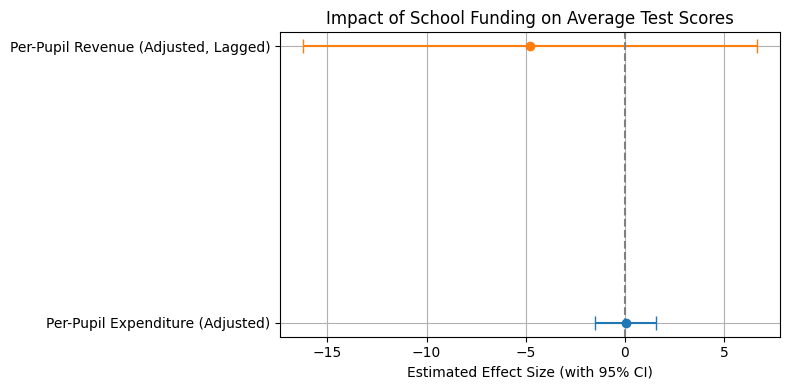

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Create the summary table again
summary_data = [
    {
        "Outcome": "AvgScaleScore",
        "Treatment": "PPE (adj)",
        "Coefficient": 0.0418,
        "StdErr": 0.776,
        "PValue": 0.957,
        "R2": 0.000
    },
    {
        "Outcome": "AvgScaleScore",
        "Treatment": "PPR (adj, lag1)",
        "Coefficient": -4.7724,
        "StdErr": 5.847,
        "PValue": 0.416,
        "R2": 0.006
    }
]

summary_data_base = [
    {
        "Outcome": "Proficient %",
        "Treatment": "PPE (adj)",
        "Coefficient": -0.0169,
        "StdErr": 0.004,
        "PValue": 0.0000328,
        "R2": 0.002,
        "Label": "All Schools"
    },
    {
        "Outcome": "Proficient %",
        "Treatment": "PPR (adj, lag1)",
        "Coefficient": -0.0117,
        "StdErr": 0.016,
        "PValue": 0.471,
        "R2": 0.001,
        "Label": "All Schools"
    }
]

summary_df = pd.DataFrame(summary_data)
summary_df["CI Lower"] = summary_df["Coefficient"] - 1.96 * summary_df["StdErr"]
summary_df["CI Upper"] = summary_df["Coefficient"] + 1.96 * summary_df["StdErr"]

# Plot: Proficient %

# Rename treatments for clarity
label_map = {
    "PPE (adj)": "Per-Pupil Expenditure (Adjusted)",
    "PPR (adj, lag1)": "Per-Pupil Revenue (Adjusted, Lagged)"
}
# Plot: AvgScaleScore
plt.figure(figsize=(8, 4))
score_df = summary_df[summary_df["Outcome"] == "AvgScaleScore"]
for idx, row in score_df.iterrows():
    label = label_map.get(row["Treatment"], row["Treatment"])
    plt.errorbar(
        row["Coefficient"],
        label,
        xerr=1.96 * row["StdErr"],
        fmt='o',
        capsize=5
    )
plt.axvline(x=0, color='grey', linestyle='--')
plt.xlabel("Estimated Effect Size (with 95% CI)")
plt.title("Impact of School Funding on Average Test Scores")
plt.grid(True)
plt.tight_layout()
plt.show()




| Outcome           | Treatment            | Coef     | StdErr | PValue    | R²    | CI Lower | CI Upper | n_total | n_treated | n_control |
|------------------|----------------------|----------|--------|-----------|-------|----------|----------|---------|-----------|-----------|
| Proficient %     | PPE (adj)            | -0.0169  | 0.004  | 0.00003   | 0.002 | -0.0250  | -0.0088  | 8124    | 4058      | 4066      |
| AvgScaleScore    | PPR (adj, lag1)      | -4.7724  | 5.847  | 0.416     | 0.006 | -16.234  | 6.689    | 118     | 58        | 60        |
| Proficient %     | PPR (adj, lag1)      | -0.0117  | 0.016  | 0.471     | 0.001 | -0.0432  | 0.0198   | 509     | 253       | 256       |
| AvgScaleScore    | PPE (adj)            | 0.0418   | 0.776  | 0.957     | 0.000 | -1.481   | 1.565    | 948     | 468        | 480       |

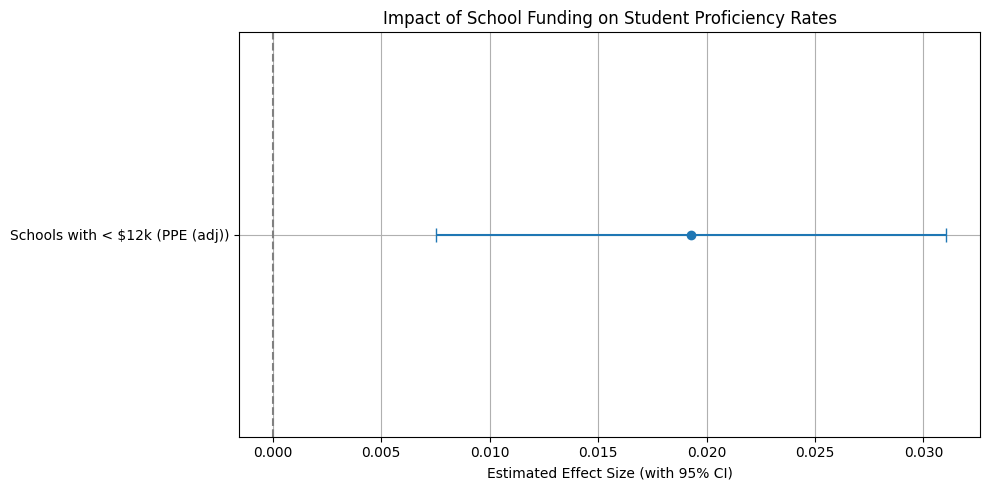

In [28]:
import matplotlib.pyplot as plt
import pandas as pd
# Existing summary data
summary_data_base = [
    {
        "Outcome": "Proficient %",
        "Treatment": "PPE (adj)",
        "Coefficient": -0.0169,
        "StdErr": 0.004,
        "PValue": 0.0000328,
        "R2": 0.002,
        "Label": "All Schools"
    },
    {
        "Outcome": "Proficient %",
        "Treatment": "PPR (adj, lag1)",
        "Coefficient": -0.0117,
        "StdErr": 0.016,
        "PValue": 0.471,
        "R2": 0.001,
        "Label": "All Schools"
    }
]

#Add new entry for schools with <12k PPE
summary_data_subgroup = {
    "Outcome": "Proficient %",
    "Treatment": "PPE (adj)",
    "Coefficient": 0.0193,
    "StdErr": 0.006,
    "PValue": 0.00214,
    "R2": 0.002,
    "Label": "Schools with < $12k"
}

summary_data = [summary_data_subgroup]
summary_df = pd.DataFrame(summary_data)

# Add confidence intervals
summary_df["CI Lower"] = summary_df["Coefficient"] - 1.96 * summary_df["StdErr"]
summary_df["CI Upper"] = summary_df["Coefficient"] + 1.96 * summary_df["StdErr"]

# Plot: Proficient %
plt.figure(figsize=(10, 5))
for idx, row in summary_df.iterrows():
    label = f"{row['Label']} ({row['Treatment']})"
    plt.errorbar(
        row["Coefficient"],
        label,
        xerr=1.96 * row["StdErr"],
        fmt='o',
        capsize=5
    )

plt.axvline(x=0, color='grey', linestyle='--')
plt.xlabel("Estimated Effect Size (with 95% CI)")
plt.title("Impact of School Funding on Student Proficiency Rates")
plt.grid(True)
plt.tight_layout()
plt.show()

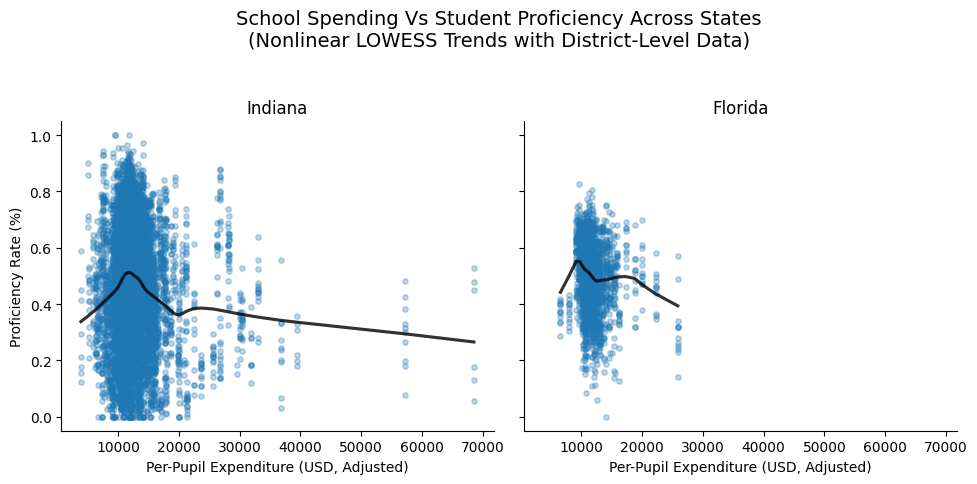

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter and select states with enough data
filtered_df = df[
    df["Per Pupil Expenditure (adj)"].notna() &
    df["ProficientOrAbove_percent"].notna()
]
top_states = filtered_df["State"].value_counts().loc[lambda s: s > 100].index
filtered_df = filtered_df[filtered_df["State"].isin(top_states)]

# Plot
g = sns.lmplot(
    x="Per Pupil Expenditure (adj)",
    y="ProficientOrAbove_percent",
    data=filtered_df,
    col="State",
    col_wrap=3,
    lowess=True,
    scatter_kws={'alpha': 0.3, 's': 15},
    line_kws={'color': 'black', 'alpha': 0.8},
    height=4,
    aspect=1.2
)

# Set axis labels and center title with better spacing
g.set_axis_labels("Per-Pupil Expenditure (USD, Adjusted)", "Proficiency Rate (%)")
g.set_titles("{col_name}", size=12)  # Smaller per-state titles

# Improve title placement
g.fig.subplots_adjust(top=0.92)
g.fig.suptitle(
    "School Spending Vs Student Proficiency Across States\n(Nonlinear LOWESS Trends with District-Level Data)",
    fontsize=14,
    y=1.2,
    x=0.35
)

plt.show()


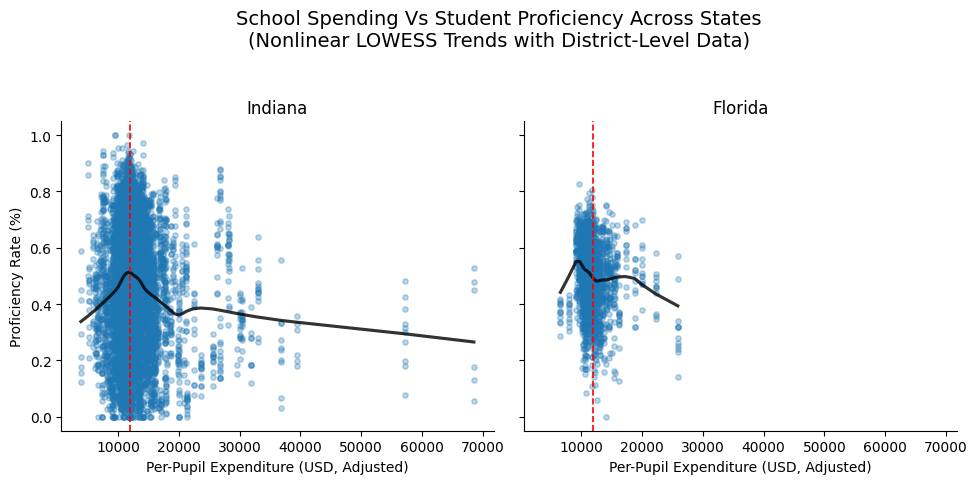

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter and select states with enough data
filtered_df = df[
    df["Per Pupil Expenditure (adj)"].notna() &
    df["ProficientOrAbove_percent"].notna()
]
top_states = filtered_df["State"].value_counts().loc[lambda s: s > 100].index
filtered_df = filtered_df[filtered_df["State"].isin(top_states)]

# Plot
g = sns.lmplot(
    x="Per Pupil Expenditure (adj)",
    y="ProficientOrAbove_percent",
    data=filtered_df,
    col="State",
    col_wrap=3,
    lowess=True,
    scatter_kws={'alpha': 0.3, 's': 15},
    line_kws={'color': 'black', 'alpha': 0.8},
    height=4,
    aspect=1.2
)

# Add vertical line at 12,000 to each subplot
for ax in g.axes.flatten():
    ax.axvline(x=12000, color='red', linestyle='--', linewidth=1.2)

# Set axis labels and title
g.set_axis_labels("Per-Pupil Expenditure (USD, Adjusted)", "Proficiency Rate (%)")
g.set_titles("{col_name}", size=12)

g.fig.subplots_adjust(top=0.92)
g.fig.suptitle(
    "School Spending Vs Student Proficiency Across States\n(Nonlinear LOWESS Trends with District-Level Data)",
    fontsize=14,
    y=1.2,
    x=0.35
)

plt.show()


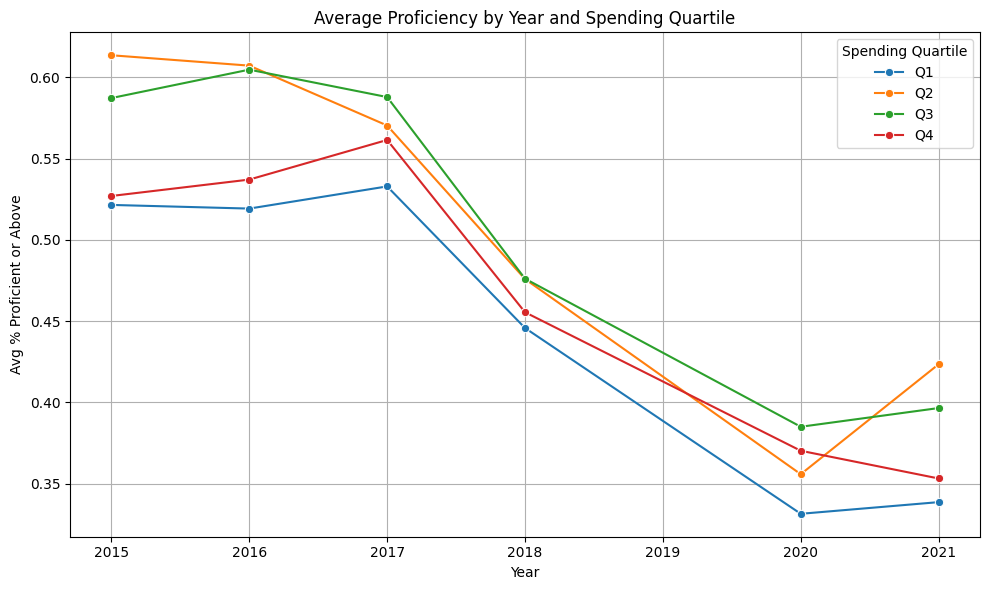

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Filter data
df_filtered = df[
    df["Per Pupil Expenditure (adj)"].notna() &
    df["ProficientOrAbove_percent"].notna() &
    df["Year_clean"].notna()
].copy()

# Bin spending into quartiles
df_filtered["spending_bin"] = pd.qcut(df_filtered["Per Pupil Expenditure (adj)"], q=4, labels=["Q1", "Q2", "Q3", "Q4"])

# Group and plot average proficiency by year and spending bin
grouped = df_filtered.groupby(["Year_clean", "spending_bin"])["ProficientOrAbove_percent"].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=grouped, x="Year_clean", y="ProficientOrAbove_percent", hue="spending_bin", marker="o")
plt.title("Average Proficiency by Year and Spending Quartile")
plt.xlabel("Year")
plt.ylabel("Avg % Proficient or Above")
plt.legend(title="Spending Quartile")
plt.grid(True)
plt.tight_layout()
plt.show()


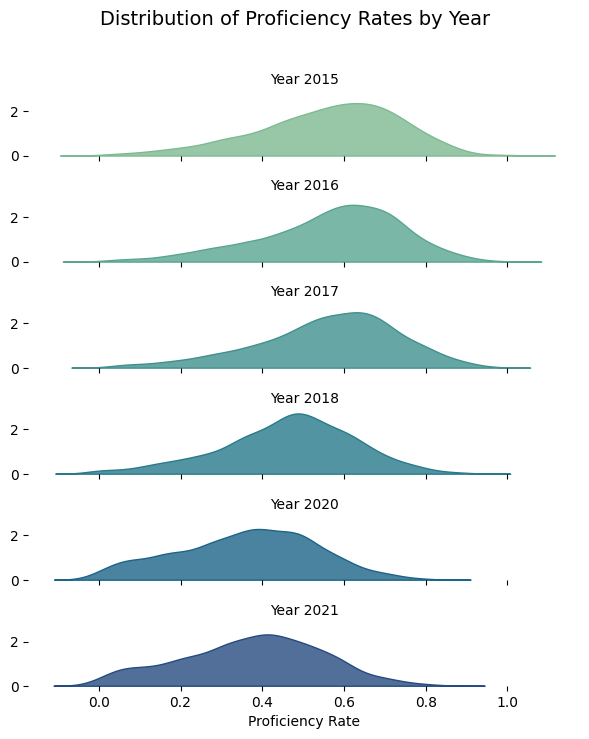

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter
df_ridge = df_filtered.copy()

# Plot with    (seaborn’s basic ridge)
g = sns.FacetGrid(df_ridge, row="Year_clean", hue="Year_clean", aspect=5, height=1.2, palette="crest", sharex=True)
g.map(sns.kdeplot, "ProficientOrAbove_percent", fill=True, alpha=0.8)
g.set_titles("Year {row_name}")
g.set_axis_labels("Proficiency Rate", "")
g.despine(bottom=True, left=True)
plt.suptitle("Distribution of Proficiency Rates by Year", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()


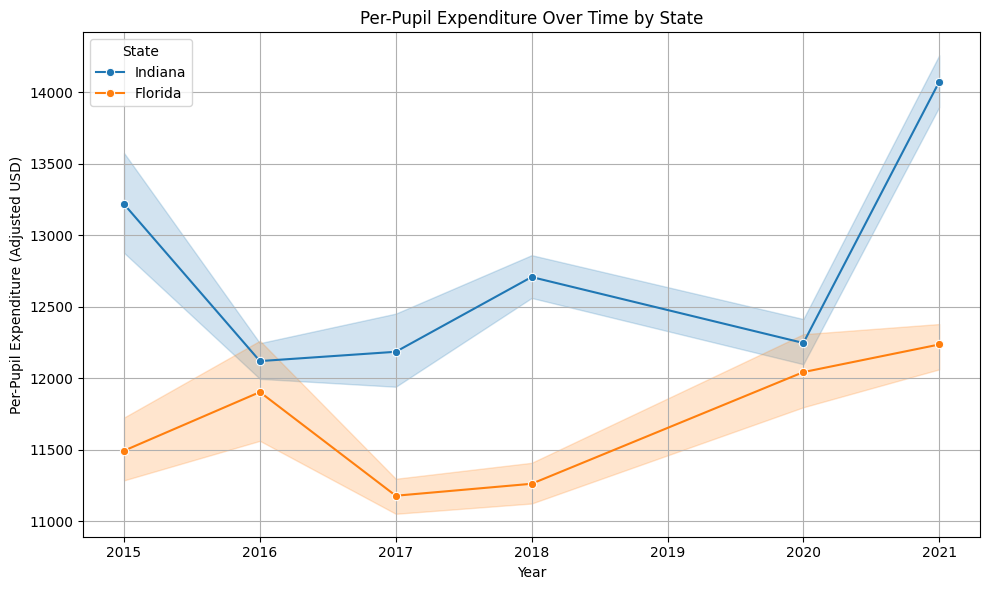

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Plotting
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df[df["State"].isin(["Florida", "Indiana"])],
    x="Year_clean",
    y="Per Pupil Expenditure (adj)",
    hue="State",
    marker="o"
)
plt.title("Per-Pupil Expenditure Over Time by State")
plt.xlabel("Year")
plt.ylabel("Per-Pupil Expenditure (Adjusted USD)")
plt.grid(True)
plt.tight_layout()
plt.show()